### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBB'#BBBSBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
13081
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    14|[90 55 A0 56 38 5...|1946.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     0|[B0 58 E0 55 B0 5...|1947.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     1|[78 5B 98 5A A0 5...|1948.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    32|[70 5A 98 5A 48 5...|1950.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     7|[00 58 90 59 C8 5...|1951.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
df.select('station').distinct().count()

116

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00092783')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00092783'
69 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     3|[00 00 00 00 00 0...|1902.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|    26|[00 00 C0 58 00 0...|1903.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     3|[80 4B 00 00 28 5...|1936.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     2|[00 00 00 00 00 0...|1937.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     2|[00 00 00 00 80 4...|1938.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



(69, 365)

In [7]:
rows = np.nan_to_num(rows)

In [11]:
np.nanmean(np.nanmean(rows,axis=1))

31.391

In [7]:
# Custom one - dont run unless required
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT DISTINCT('%s'), elevation FROM weather\n\tWHERE measurement='%s'"%('station', 'SNOW')
Query="SELECT elevation, vector, station, latitude, longitude FROM weather\n\tWHERE measurement='%s'"%('SNOW')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
rows=df1.rdd.map(lambda row:[unpackArray(row['vector'],np.float16), row['elevation'],row['station'],row['latitude'],row['longitude']]).collect()
print (len(rows), len(rows[0]))

SELECT elevation, vector, station, latitude, longitude FROM weather
	WHERE measurement='SNOW'
2125 rows
+---------+--------------------+-----------+--------+---------+
|elevation|              vector|    station|latitude|longitude|
+---------+--------------------+-----------+--------+---------+
|     36.6|[00 00 00 00 00 0...|USC00095386| 31.9297| -82.6792|
|     36.6|[00 00 00 00 00 0...|USC00095386| 31.9297| -82.6792|
|     36.6|[00 00 00 00 00 0...|USC00095386| 31.9297| -82.6792|
|     36.6|[00 00 00 00 00 0...|USC00095386| 31.9297| -82.6792|
|     36.6|[00 00 00 00 00 0...|USC00095386| 31.9297| -82.6792|
+---------+--------------------+-----------+--------+---------+
only showing top 5 rows

(2125, 5)


In [8]:
rows[0]

[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [12]:
new_arr = []
total_cols = 0
for i in range(len(rows)):
    rows
    if (np.nan_to_num(rows[i][0]).any() > 0):
        total_cols += 1
        new_arr.append(rows[i])
print (total_cols) # number of distinct snowing entries across years
l = set()
indices = []
for i in range(len(new_arr)):
    if (new_arr[i][2] not in l):
        l.add(new_arr[i][2])
        indices.append(i)
print (len(l)) # number of stations which had snow!

22
8


In [13]:
final = []
for i in range(len(indices)):
    final.append(new_arr[indices[i]])
#print (final[:10])

In [14]:
df_final = pd.DataFrame(final)
df_final.head(5)

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,15.0,0.0,229.0,0.0,53.0,38.0,330.0,0.0,23.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,13.0
1,508.0,0.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0,...,0.0,345.0,0.0,0.0,0.0,46.0,0.0,330.0,0.0,0.0
2,699.0,330.0,457.0,213.0,0.0,0.0,0.0,0.0,142.0,41.0,...,0.0,114.0,0.0,0.0,0.0,0.0,224.0,0.0,0.0,0.0
3,76.0,188.0,20.0,0.0,0.0,0.0,38.0,0.0,0.0,91.0,...,0.0,178.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,279.0
4,147.0,183.0,51.0,0.0,0.0,0.0,38.0,102.0,145.0,0.0,...,0.0,0.0,0.0,0.0,0.0,279.0,25.0,0.0,0.0,246.0


In [15]:
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T#/10.  # scaling to make the temperature be in centingrates
print shape(T)
total_cols = 0
T_bkp = T
for i in range(len(T[0])):
    if np.count_nonzero(T[:,i]) > 0:
        total_cols += 1
print total_cols

69 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     3|[00 00 00 00 00 0...|1902.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|    26|[00 00 C0 58 00 0...|1903.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     3|[80 4B 00 00 28 5...|1936.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     2|[00 00 00 00 00 0...|1937.0|BSBSSSBB|
|     71.0| 31.4889| -82.8206|       PRCP|USC00092783|     2|[00 00 00 00 80 4...|1938.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows

(69, 365)
365


In [16]:
len (T_bkp[:,0])

69

### Script for plotting yearly plots

(69, 365)


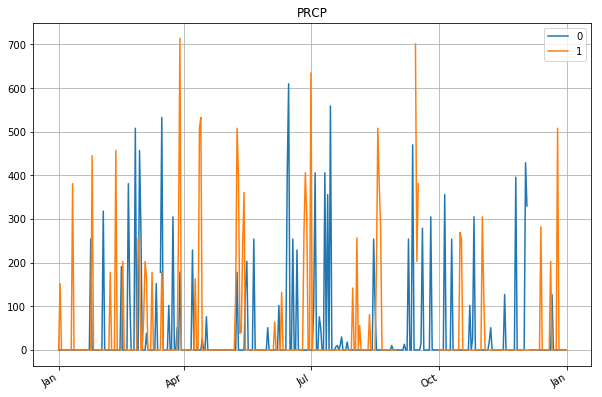

In [17]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
print T.shape
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [18]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


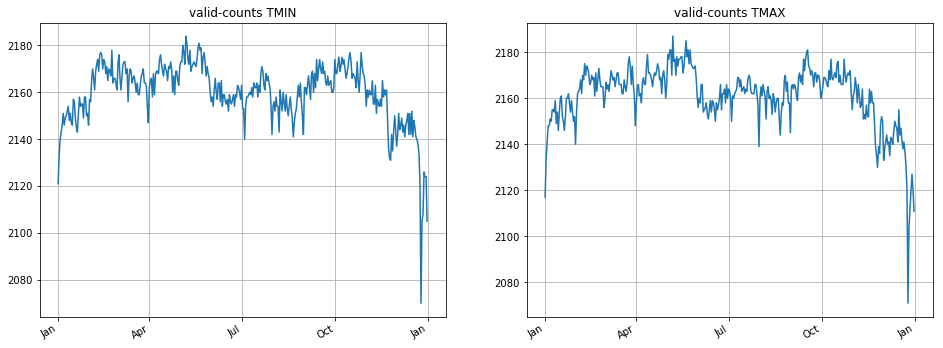

In [19]:
plot_pair(['TMIN','TMAX'],plot_valid)

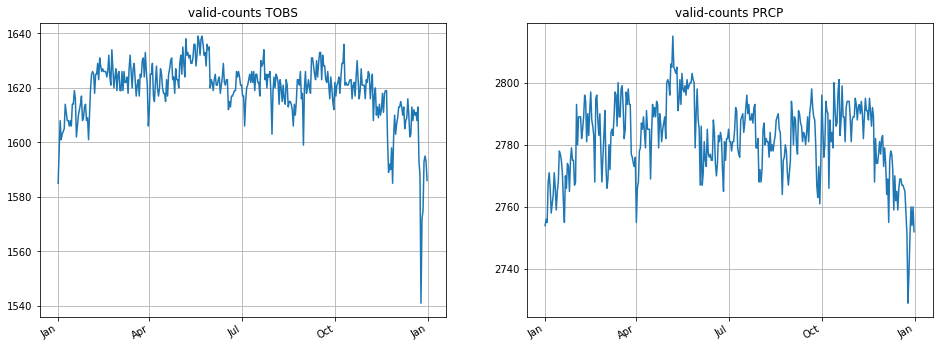

In [20]:
plot_pair(['TOBS','PRCP'],plot_valid)

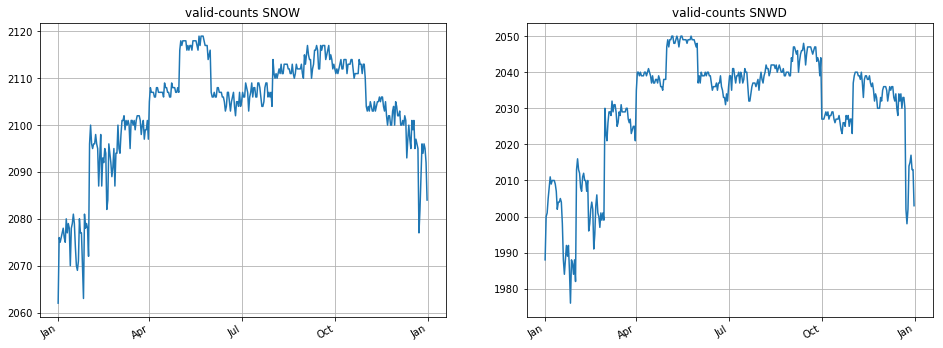

In [21]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [27]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    if (m in ['TMIN', 'TMAX', 'TOBS']):
        graphs=graphs/10
        ylabel = 'Degree Celsius'
    else:
        graphs=graphs/10
        ylabel = 'Millimeters'
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m, labels=['Mean-Std', 'Mean', 'Mean+Std'],xlabel='Months',ylabel=ylabel)

def plot_mean(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean]).transpose()
    if (m in ['TMIN', 'TMAX', 'TOBS', 'PRCP']):
        graphs=graphs/10
    YP.plot(graphs,fig,axis,title='Mean'+m)
    print (np.sum(mean)/len(mean))

In [ ]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

In [ ]:
plot_pair(['TMIN','TMAX'],plot_mean)

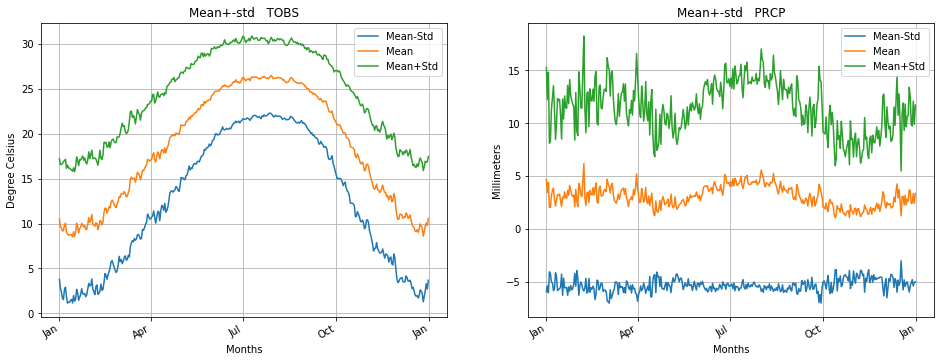

In [28]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
#plot_pair(['TOBS','PRCP'],plot_mean)

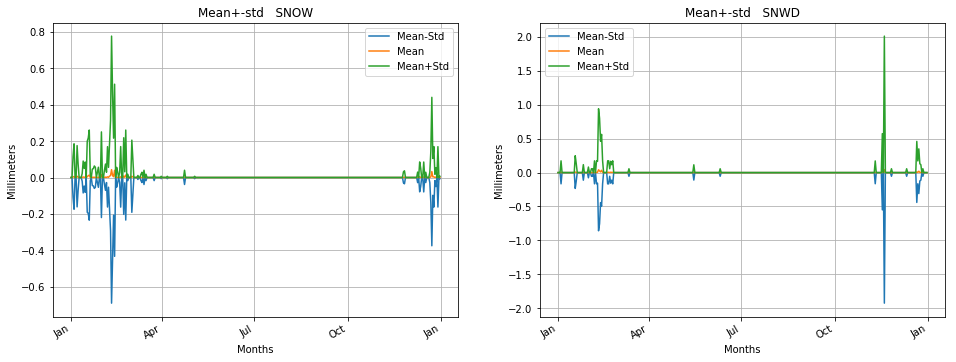

In [29]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
#plot_pair(['SNOW', 'SNWD'],plot_mean)

### plotting top 3 eigenvectors

In [40]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    EVal = STAT[m]['eigval']
    print (EVal)
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

[  7.62708394e+04   2.97781505e+04   2.47291181e+04   2.25058956e+04
   2.21252737e+04   2.11917193e+04   1.87601841e+04   1.72274966e+04
   1.60089293e+04   1.54074458e+04   1.50329532e+04   1.43422077e+04
   1.38938033e+04   1.34657314e+04   1.27441488e+04   1.19928805e+04
   1.15497442e+04   1.13140994e+04   1.10835684e+04   1.08029640e+04
   1.01981186e+04   9.75117676e+03   9.60078070e+03   9.24142112e+03
   8.84945130e+03   8.69383442e+03   8.06830135e+03   7.96843294e+03
   7.66130397e+03   7.44679071e+03   7.33510917e+03   7.02677704e+03
   6.86993402e+03   6.72304448e+03   6.54389023e+03   6.33280993e+03
   6.18476100e+03   6.07446129e+03   5.70372371e+03   5.32961847e+03
   5.11647264e+03   5.02091571e+03   4.85495712e+03   4.69580572e+03
   4.67982050e+03   4.52467608e+03   4.43400496e+03   4.34087269e+03
   4.20809662e+03   4.13770800e+03   4.06871800e+03   3.87891479e+03
   3.81835231e+03   3.69446754e+03   3.56519382e+03   3.46672859e+03
   3.42571871e+03   3.31887743e+03

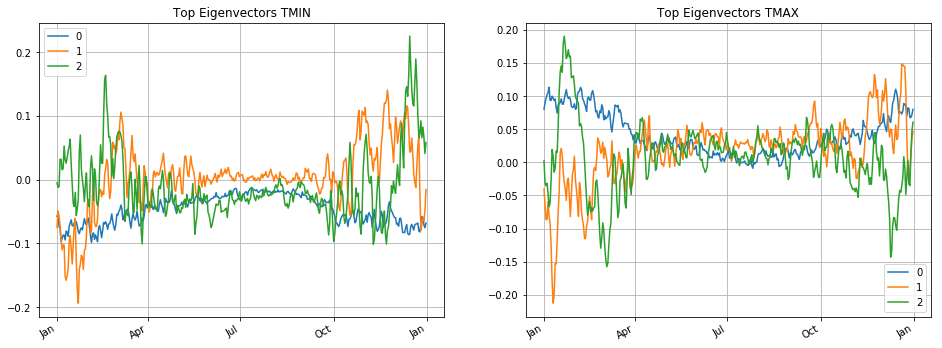

In [41]:
plot_pair(['TMIN','TMAX'],plot_eigen)

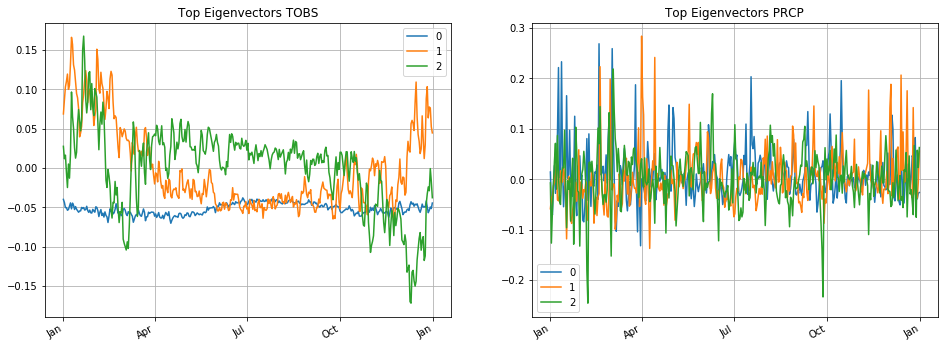

In [32]:
plot_pair(['TOBS','PRCP'],plot_eigen)

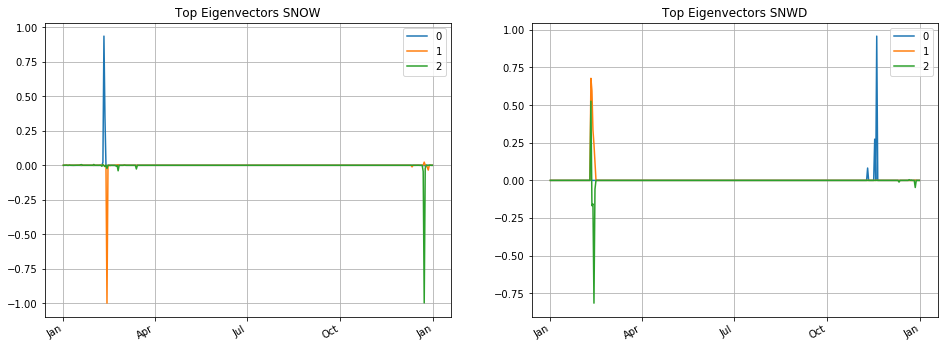

In [33]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [36]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    print (list(cumsum(EV[:k]))/sum(EV))
    grid()
    

[ 0.1008504   0.14022506  0.17292355  0.20268235  0.23193787]
[ 0.4539579   0.4816837   0.5015975   0.51851128  0.53457806]
[ 0.0950761   0.13447649  0.17088092  0.20182823  0.23026139]


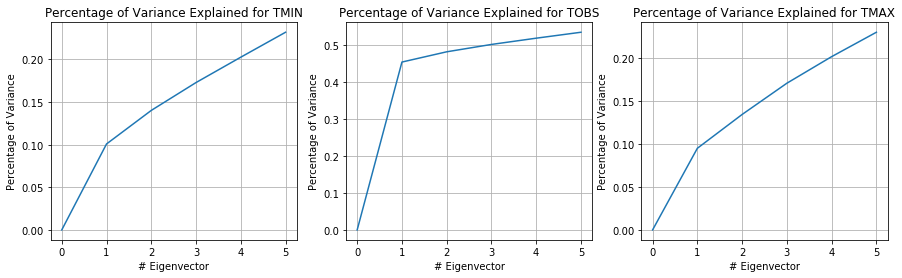

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

[ 0.3051605   0.42027995  0.50605694  0.58033969  0.62712739]
[ 0.61298302  0.8368933   0.86995185  0.89934238  0.92017614]
[ 0.01413125  0.02729697  0.03942903  0.05103181  0.06237922]


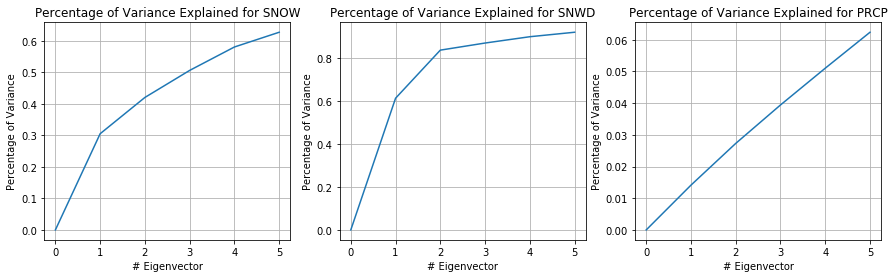

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [39]:
sc.stop()